<a href="https://colab.research.google.com/github/acedesci/scanalytics/blob/master/EN/S06_Time-Series_Analytics/Demo_Dynamic_inventory_policy_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Demo: inventory policy performance simulation from time-series forecasts

This demo is a supplementary resource to demonstrate how we can use the inventory simulation developed earlier to evaluate the quality of the inventory policies based on the forecats produced by different forecasting models. The target stock calculations must be provided together with the actual demands (saved from the other notebook on time-series forecasts). Then the inventory performances are measured by different inventory measures. The two key measures are the fill rate (% quantity fulfilled on-time) and inventory turnover. These two measures provide the trade-off and the overall inventory performance is based on the average ranking of the fill rate and turnover of each policy.

In [ ]:
def inventory_simulation_dynamic_basestock_policy(demand_series, target_series, init_inv, lead_time, model_name = ''):


  # Parameters to set min and max policy
  # Dynamic basestock policy - set the min and max using the target stock from the series
  s_min =  0 # this is the small s
  s_max =  0 # this is the big s

  demand_series.head()
  # creating an (empty) dataframe to keep the results
  column_names = ['Start_Inv', 'Receipt', 'Demand', 'Ending_Inv', 'Order']
  n_weeks = len(demand_series.index)

  demand_series.index = range(1, n_weeks+1)
  target_series.index = range(1, n_weeks+1)
  inv_dataframe = pd.DataFrame(index = range(1, n_weeks+1), columns=column_names)
  inv_dataframe.index.name ='Week' # give the index name to the output dataframe
  inv_dataframe.head()

  # initializing current inventory levels and order receipt up to t=lead_time
  inv_dataframe.loc[1, 'Start_Inv'] = init_inv
  for t in range(1, lead_time+1):
      inv_dataframe.loc[t,'Receipt']=0

  # add the values to demand column from the series
  inv_dataframe['Demand'] = demand_series
  inv_dataframe.head() # review the result

  # assign values to the entries of the dataframe
  for t in range(1, n_weeks+1):
      # dynamic basestock policy - set the min and max using the target stock from the series
      s_min = target_series.loc[t]
      s_max = target_series.loc[t]
      # computing inventory levels at the begining and end of each period
      if t > 1: # set the Start_Inv equals the inv level at the end of the previous period (Ending_Inv)
          inv_dataframe.loc[t, 'Start_Inv'] = inv_dataframe.loc[t-1, 'Ending_Inv']

      # Calculate inventory flow for Ending_Inv of the current period
      inv_dataframe.loc[t, 'Ending_Inv'] = inv_dataframe.loc[t, 'Start_Inv'] + inv_dataframe.loc[t,'Receipt'] - inv_dataframe.loc[t, 'Demand']

      # Calculating orders and receipts for period t
      intransit_quantity = sum(inv_dataframe.loc[t+1:t+lead_time-1,'Receipt']) # check the intransit (outstanding) order within the leadtime

      if inv_dataframe.loc[t,'Ending_Inv'] + intransit_quantity < s_min: # if 'Ending_Inv' + intransit < s_min in this case an order must be placed
          # create an order Q = s_max - current inventory position
          inv_dataframe.loc[t,'Order'] = s_max - (inv_dataframe.loc[t,'Ending_Inv']+ intransit_quantity)
          # check if we reach the end of dataframe, if not, we add the order receipt after the leadtime
          if t + lead_time <= max(inv_dataframe.index):
              inv_dataframe.loc[t+lead_time,'Receipt'] = inv_dataframe.loc[t,'Order']
      else:
          inv_dataframe.loc[t,'Order'] = 0   # no order is placed if 'Ending_Inv' >= s_min
          if t + lead_time <= max(inv_dataframe.index):
              inv_dataframe.loc[t+lead_time,'Receipt'] = 0  # no orders receipt in t+leadtime periods

  backlog_num = inv_dataframe['Ending_Inv'].lt(0).sum()
  backlog_total_units = inv_dataframe['Ending_Inv'].loc[inv_dataframe['Ending_Inv'] < 0].sum() #this number is negative
  demand_total = inv_dataframe['Demand'].sum()
  order_total = inv_dataframe['Order'].sum()
  order_num = inv_dataframe['Order'].gt(0).sum()
  inv_total_units = inv_dataframe['Ending_Inv'].loc[inv_dataframe['Ending_Inv'] > 0].sum()
  fill_rate = ((demand_total + backlog_total_units)/demand_total)
  avg_demand = inv_dataframe['Demand'].mean()
  inv_turnover = (avg_demand*52)/(inv_total_units/n_weeks)



  print("Performance of dynamic base stock under model: ", model_name)
  print("\tTotal number of orders =",order_num,", Average order quantity =","{:.2f}".format(order_total/order_num))
  print("\tAverage inventory per week =", "{:.2f}".format(inv_total_units/n_weeks))
  print("\tAverage number of backlogged units per week =", "{:.2f}".format(backlog_total_units/n_weeks))
  print("\tN. backlog incidents =", inv_dataframe['Ending_Inv'].lt(0).sum())
  print("\tService Level =", "{:.2f}".format(( 1 - backlog_num/n_weeks)*100),"%") # % of times the demand is completely fulfilled
  print("\tFill rate =", "{:.2f}".format(fill_rate*100),"%")
  print("\tInventory Turnover (Ending) =", "{:.2f}".format(inv_turnover))

  return inv_dataframe['Ending_Inv'][lead_time:], fill_rate, inv_turnover



In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive/')

demand = pd.read_csv('/content/drive/My Drive/test_forecasts.csv')
target_stocks = pd.read_csv('/content/drive/My Drive/target_stocks.csv')

demand.head()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


,ds,y,NaiveSeasonal(K,AutoARIMA(),Theta(season_mo,Prophet(),Croston(),NaiveEnsembleMo,RegressionEnsem
0,2015-05-31,31,15.0,30.563124,25.865677,22.941515,26.467385,22.444354,28.707318
1,2015-06-07,33,15.0,28.137307,24.229022,19.250786,26.467385,21.898802,25.638553
2,2015-06-14,28,18.0,25.379339,27.342368,15.400309,26.467385,23.936584,30.754771
3,2015-06-21,23,10.0,24.818764,26.813186,15.424187,26.467385,21.093523,31.686216
4,2015-06-28,37,16.0,24.818423,25.819059,19.390405,26.467385,22.762148,28.379450


Index(['NaiveSeasonal(K', 'AutoARIMA()', 'Theta(season_mo', 'Prophet()',
       'Croston()', 'NaiveEnsembleMo', 'RegressionEnsem'],
      dtype='object')
Initial inventory: 128
Performance of dynamic base stock under model:  NaiveSeasonal(K
	Total number of orders = 49 , Average order quantity = 43.90
	Average inventory per week = 18.93
	Average number of backlogged units per week = -4.93
	N. backlog incidents = 21
	Service Level = 59.62 %
	Fill rate = 88.41 %
	Inventory Turnover (Ending) = 116.80
Performance of dynamic base stock under model:  AutoARIMA()
	Total number of orders = 50 , Average order quantity = 43.78
	Average inventory per week = 26.43
	Average number of backlogged units per week = -3.64
	N. backlog incidents = 11
	Service Level = 78.85 %
	Fill rate = 91.43 %
	Inventory Turnover (Ending) = 83.65
Performance of dynamic base stock under model:  Theta(season_mo
	Total number of orders = 50 , Average order quantity = 43.78
	Average inventory per week = 25.61
	Average numbe

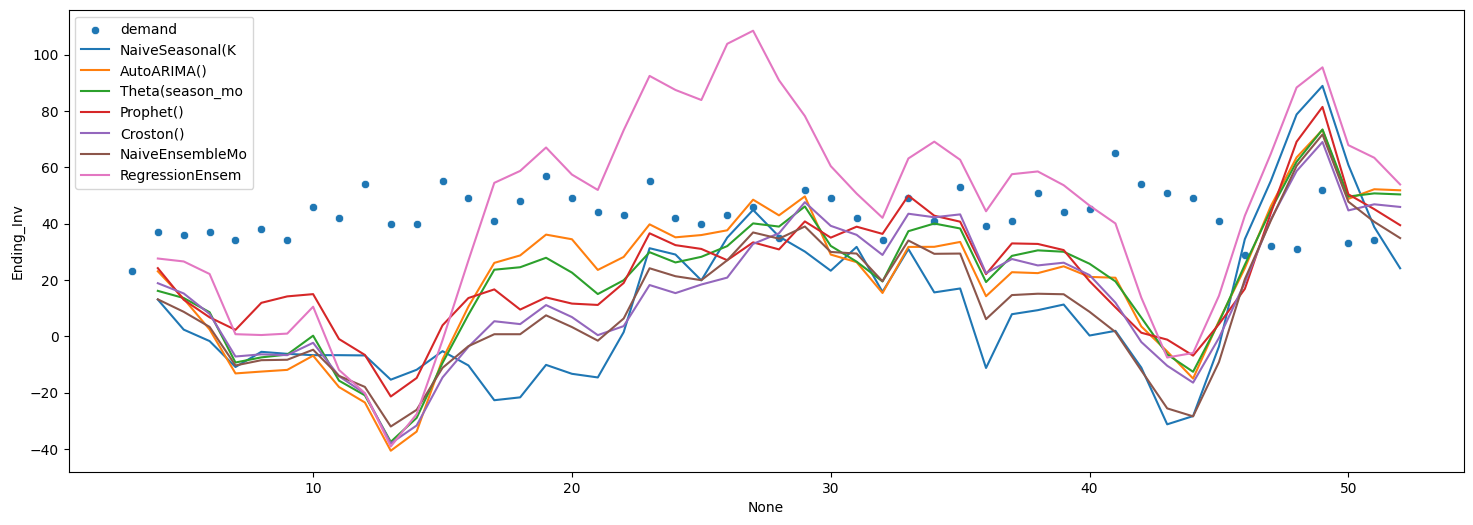

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

list_models = target_stocks.columns[2:]
print(list_models)

demand_series = demand['y']

# Parameters for the model
init_inv = int(target_stocks['y'].mean())  # initial inventory level
print("Initial inventory: "+str(init_inv))
lead_time = 3  # leadtime

results = pd.DataFrame(columns = ["FillRate", "InvTurn"], index = list_models)

plt.figure(figsize=(18,6))

sns.scatterplot(x = demand_series[lead_time:].index, y = demand_series[lead_time:].values, label = 'demand')

for model in list_models:
  target_series = target_stocks[model]
  ending_inv, fill_rate, avg_inv = inventory_simulation_dynamic_basestock_policy(demand_series, target_series, init_inv, lead_time, model_name = model)
  sns.lineplot(data = ending_inv, label = model)
  results.loc[model, "FillRate"] = fill_rate
  results.loc[model, "InvTurn"] = avg_inv

results['Model'] = results.index

<ipython-input-12-a9f10cc3084b>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(x[i], y[i], labels[i], fontsize=8)


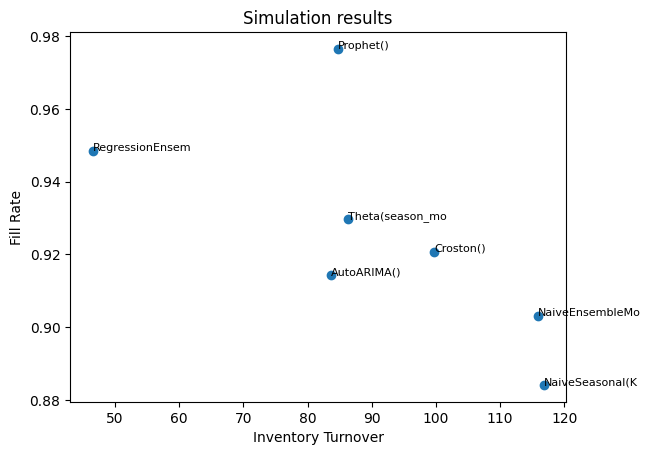

In [ ]:
import matplotlib.pyplot as plt

x = results['InvTurn']
y = results['FillRate']
labels = results['Model']
# Create the scatter plot
plt.scatter(x, y)

# Add labels to each point
for i in range(len(x)):
    plt.text(x[i], y[i], labels[i], fontsize=8)

# Set plot labels and title

plt.xlabel('Inventory Turnover')
plt.ylabel('Fill Rate')
plt.title('Simulation results')

# Show the plot
plt.show()

In [ ]:
results

,FillRate,InvTurn,Model
NaiveSeasonal(K,0.97646,34.9181,NaiveSeasonal(K
AutoARIMA(),0.998375,49.730483,AutoARIMA()
Theta(season_mo,0.993242,51.357091,Theta(season_mo
Prophet(),0.983637,43.016492,Prophet()
Croston(),0.991667,53.282132,Croston()
NaiveEnsembleMo,0.995507,49.002651,NaiveEnsembleMo
RegressionEnsem,0.998729,49.630304,RegressionEnsem
